In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class grounded_curve(nn.Module):
    def __init__(self, input_dim, hidden_dim, x0, x1, scale_factor = 5 ):
        super().__init__()
        self.mod = nn.Sequential(nn.Linear(1,hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim,hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim,hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim,input_dim))
        self.scale_factor = scale_factor

        self.x0 = x0
        self.x1 = x1
        
    def forward(self, t):
        """
        x0 : N x d
        x1 : N x d
        t : T

        output : T x N x d
        """
        avg = t * self.x1 + (1-t) * self.x0
        enveloppe = self.scale_factor * (1- (t*2-1)**2)
        outs =  self.mod(t) * enveloppe + avg

        return outs


def sphere_geodesic_torch(x0, x1, t):
    """|
    x0 : N x d
    x1 : N x d
    t : T

    Returns : T x N x d
    """

    vx = torch.cos(x0[:,0]) * torch.sin(x0[:,1])
    vy = torch.sin(x0[:,0]) * torch.sin(x0[:,1])
    vz = torch.cos(x0[:,1])

    wx = torch.cos(x1[:,0]) * torch.sin(x1[:,1])
    wy = torch.sin(x1[:,0]) * torch.sin(x1[:,1])
    wz = torch.cos(x1[:,1])

    v = torch.stack([vx,vy,vz],-1)
    w = torch.stack([wx,wy,wz],-1)

    u = w - ((v*w).sum(1))[:,None] * v
    u = u / torch.linalg.norm(u, dim = 1)[:,None]

    c = torch.arccos(((v*w).sum(1)))

    alpha = torch.cos(t[:,None] * c[None,:])[...,None] * v[None,:] + torch.sin(t[:,None] * c[None,:])[...,None] * u[None,:]


    v = torch.arccos(alpha[...,2])
    cosu = alpha[...,0] / torch.sin(v)
    sinu = alpha[...,1] / torch.sin(v)
    u = torch.atan2(sinu,cosu)

    return alpha , torch.stack([u,v], -1)

In [3]:
input_dim = 2
hidden_dim = 16

x0 = torch.cat([torch.Tensor(np.random.rand(1,1)) * 2* torch.pi - torch.pi,torch.Tensor(np.random.rand(1,1)) * 0.5*(torch.pi) ],dim=1)[0]
x1 = torch.cat([torch.Tensor(np.random.rand(1,1)) * 2* torch.pi - torch.pi,torch.Tensor(np.random.rand(1,1)) * 0.5*(torch.pi) ],dim=1)[0]
t = torch.linspace(0,1,100)[:,None]

In [4]:
def metric(out):
    m = torch.eye(2)[None,...].repeat(out.shape[0],1,1)
    m[:,0,0] = torch.sin(out[:,1]).pow(2)
    return m

curve = grounded_curve(input_dim, hidden_dim, x0, x1, scale_factor = 1)

optimizer = torch.optim.Adam(curve.parameters(), lr=0.001)

In [5]:
losses = []
for _ in range(250):

    optimizer.zero_grad()

    jac = torch.autograd.functional.jacobian(curve.forward, t,create_graph=True)
    jac = torch.einsum("tntd->tnd",jac)[...,0]

    out = curve(t)
        
    m = metric(out)

    pre_prod = torch.einsum('tb,tbj->tj',jac,m)
    prod = torch.einsum('tb,tb->t', pre_prod, jac)

    loss = prod.mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())

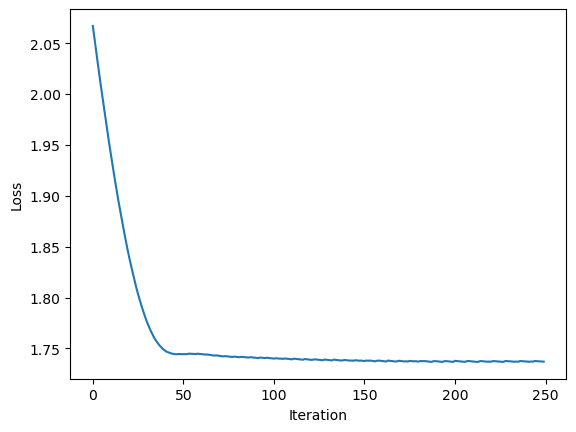

In [6]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

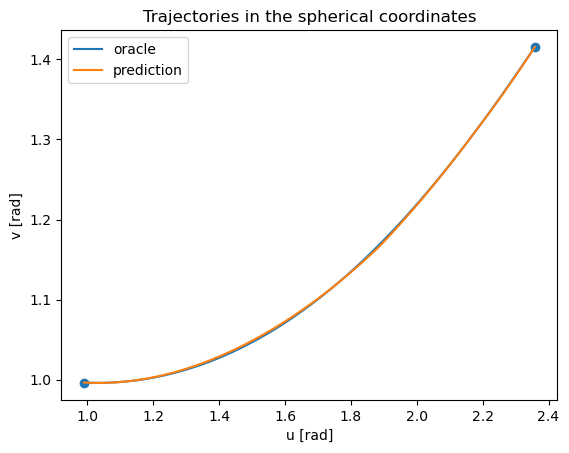

In [7]:
oracle = sphere_geodesic_torch(x0[None],x1[None],t)[1]
out = curve(t).detach().numpy()

t_idx_sorted = torch.argsort(t)
plt.figure()
plt.scatter(x=[x0[0].item(), x1[0].item()],y = [x0[1].item(), x1[1].item()])
plt.plot(oracle[:,0,0,0], oracle[:,0,0,1], label = "oracle")
plt.plot(out[:,0], out[:,1], label = "prediction")
plt.xlabel("u [rad]")
plt.ylabel("v [rad]")
plt.title("Trajectories in the spherical coordinates")
plt.legend()
plt.show()

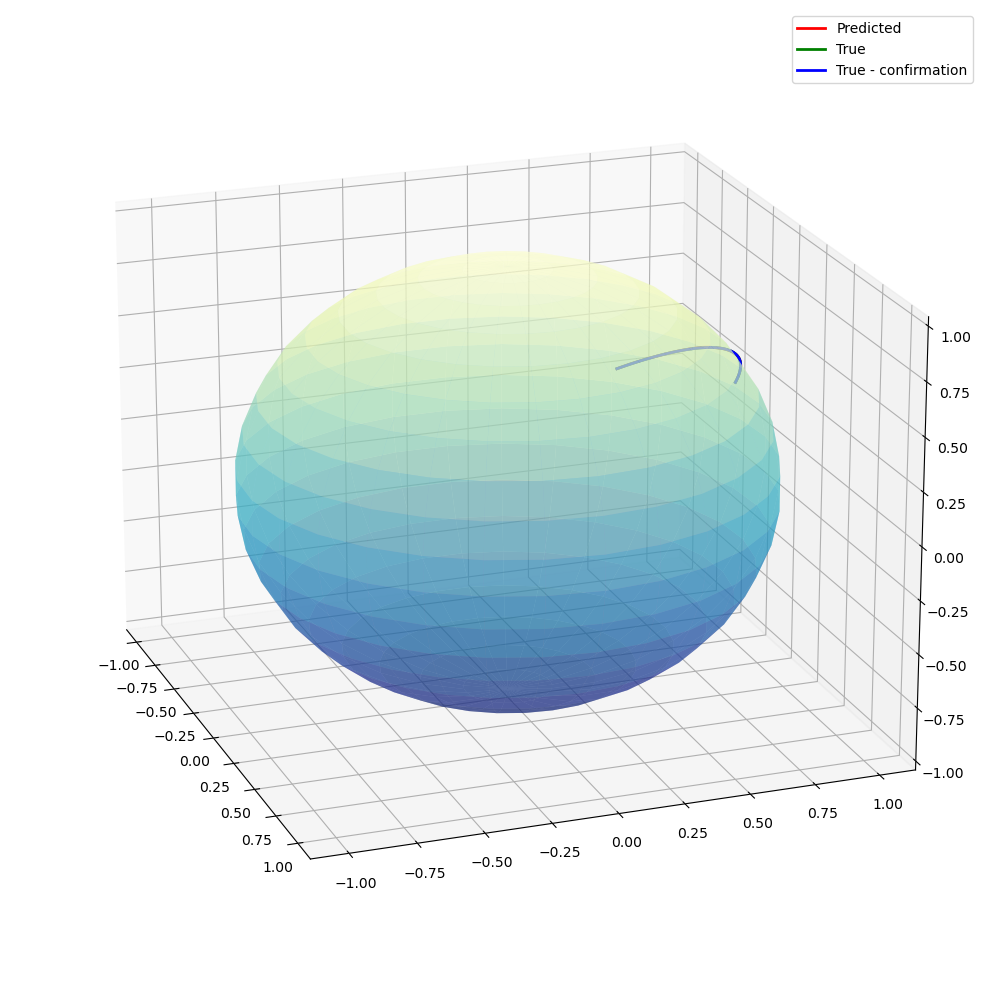

In [8]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
r = 0.05
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)

u_pred = out[:,0]
v_pred = out[:,1]

x_pred = np.cos(u_pred) * np.sin(v_pred)
y_pred = np.sin(u_pred) * np.sin(v_pred)
z_pred = np.cos(v_pred)

geo_true, coords_true = sphere_geodesic_torch(x0[None],x1[None],t)
geo_true = geo_true[:,0,0,:].numpy()
coords_true = coords_true[:,0,0,:].numpy()

x_true = geo_true[:,0]
y_true = geo_true[:,1]
z_true = geo_true[:,2]

u_true = coords_true[:,0]
v_true = coords_true[:,1]
x_true2 = np.cos(u_true) * np.sin(v_true)
y_true2 = np.sin(u_true) * np.sin(v_true)
z_true2 = np.cos(v_true)

ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha = 0.5)
ax.plot(x_pred,y_pred,z_pred,c="r",linewidth=2, label = "Predicted")
ax.plot(x_true,y_true,z_true,c="g",linewidth=2, label = "True")
ax.plot(x_true2,y_true2,z_true2,c="b",linewidth=2, label = "True - confirmation")
ax.view_init(20, -20)

plt.legend()
plt.show()